In [5]:
import numpy             as np
import matplotlib.pyplot as plt
from astropy import units as units

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates
from src.input          import setinput, getcst

from scipy.integrate    import solve_ivp
from astropy            import constants

In [2]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()

## input values physics
ρ, T, δ, Av, chemtype = setinput()

## input chemistry
chemtype = 'C'

## calculate H accretion on dust
Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

yr_to_sec = units.year.to('s')         ## year in seconds

Input:
------
ρ  = 1.13E+05
T  = 2500.0
δ  = 1.0
Av = 0.5

Chem type = C


In [3]:
n, nconsv, specs = initialise_abs(chemtype)     # n_consv = TOTAL in fortran code
timesteps = 1

ndot        = np.zeros(len(n))
nconsvdot   = np.zeros(len(nconsv))
t           = np.zeros(timesteps)

k = calculate_rates(T, δ, Av)

In [4]:
t=0.0
# ODE(t, n, n_consv, ndot, X, k, ρ, Haccr)

In [7]:
Δt = 1.0e+2*yr_to_sec  ## in sec

Δt = 1.e+2

solution = solve_ivp(
    fun          = ODE,
    t_span       = [0.0, Δt],
    y0           = n,
    method       = 'BDF',   ## zoals DVODE
    args         = (ndot, nconsvdot, nconsv,k, ρ, Haccr),
    dense_output = False    ## if True: returns interpolation function
)

assert solution['status'] == 0

ys = solution['y']
ts = solution['t']

print(solution['message'])

The solver successfully reached the end of the integration interval.


(1e-40, 1.0)

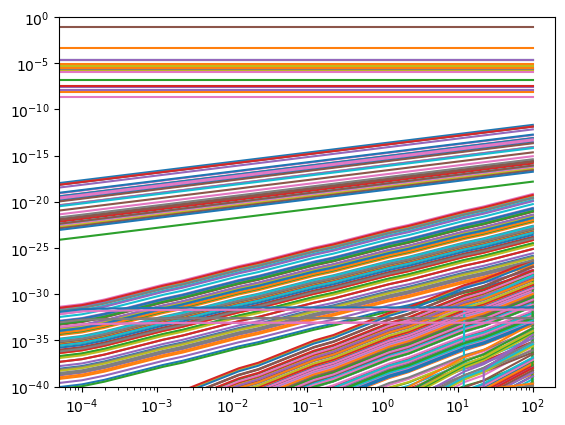

In [10]:
for i in range(ys.shape[0]):
    plt.plot(ts, ys[i])
# for j in x:
#     plt.plot(ts, ys[j],'k')
plt.yscale('log')
plt.xscale('log')

plt.ylim((1.0e-40, 1.0e+0))
